### Importing Modules

In [2]:
import pandas as pd
import numpy as np
import nltk
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


### Creating a dataframe

In [3]:
train_df = pd.read_csv('train.csv',nrows=1000)
test_df = pd.read_csv('test.csv',nrows=1000)

### Preprocessing

In [4]:
train_df.drop_duplicates(['highlights'], inplace=True)
test_df.drop_duplicates(['highlights'], inplace=True)
train_df = train_df.drop(['id'], axis= 1)
train_df.reset_index(inplace=True, drop=True)
test_df = test_df.drop(['id'], axis= 1)
test_df.reset_index(inplace=True, drop=True)

In [5]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

#### Removes HTML Tags
#### Text inside parenthesis
#### Removes very short words
#### Removes double quotes and apostrophe's
#### Lowers the text

In [6]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in train_df['article']:
    cleaned_text.append(text_cleaner(t))

In [7]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in train_df['highlights']:
    cleaned_summary.append(summary_cleaner(t))

train_df['article']=cleaned_text
train_df['highlights']=cleaned_summary
train_df['highlights'].replace('', np.nan, inplace=True)
train_df.dropna(axis=0,inplace=True)

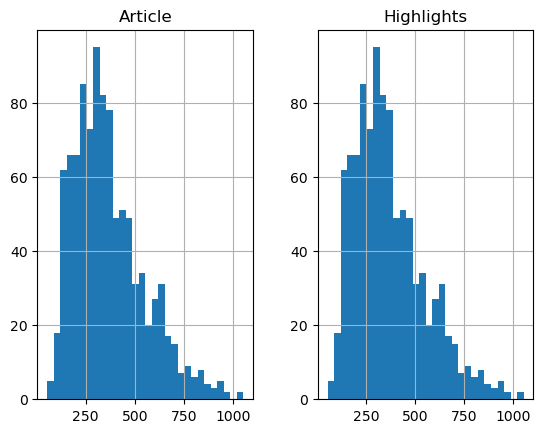

In [20]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['article']:
      text_word_count.append(len(i.split()))

for i in train_df['article']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Article':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [8]:
from sklearn.utils import shuffle
train_df_shuffled = shuffle(train_df, random_state=42)  # random_state for reproducibility
subset_size = int(0.1 * len(train_df_shuffled)) # take 0.25 of data length
train_df = train_df_shuffled.iloc[:subset_size]
train_df

,article,highlights
521,wayne rooney manchester united team mates celebrating sunday night beat liverpool move five points clear rivals race champions league football juan mata scored goals captain rooney took twitter co...,manchester united beat liverpool to move five points clear in th place juan mata scored twice while wayne rooney also missed penalty united captain rooney took to twitter to congratulate mata he a...
737,christopher higgs relationships four women defrauded order fund gambling addiction police officer jailed defrauded four vulnerable women tens thousands pounds order fund gambling addiction christo...,pc christopher higgs defrauded four women of in total defrauded victims to fund gambling addiction which cost him he emotionally blackmailed them by claiming to be depressed and suicidal when that...
740,school friends fire whole pantry founder belle gibson query whether health guru invented stories get sympathy warned people vaccination high school gibson spotlight week doubts raised remarkable c...,whole pantry founder belle gibson has come under fire this week after friends raised doubts about her cancer survival story and charity donations former school mates now query whether the drama qu...
660,target charles dickens victim attempted attack carriage charles dickens today venerated one england greatest ever literary heroes always treated respect newly rediscovered records reveal height fa...,the great novelist was the subject of an attempted highway robbery in when criminal tried to overturn his carriage dickens escaped harm because he had missed the train he usually took records unea...
411,may suffering effects dislocated shoulder golf legend arnold palmer vowed stop hitting ceremonial opening tee shot masters augusta next month year old speaking reporters trump doral resort opening...,four time masters winner suffered dislocated shoulder in december he has struck ceremonial opening tee shot at masters since doctors will not allow him to swing golf club yet he vows to be out on ...
...,...,...
436,home self declared baddest man planet scene many wild party derelict mansion still dripping gold marble set transformed church spacious home southington ohio owned heavyweight champion boxer mike ...,vast mansion in southington ohio was boxer home during the late and early it features mirrored ceiling jacuzzi and swimming pool twice the size of the average family home tyson was forced to sell ...
764,midwife sister christine lee within sentimental world sunday night television call midwife heroine jenny lee played gentle reserve actress jessica raine call midwife heroine jenny lee based real p...,jenny lee life was turned upside down when her parents divorced she became violent after her mother married bully called jock she turned to midwifery after being dismissed from nursing course jenn...
88,georgia state coach whose son led seed upset baylor ncaa men basketball tournament thursday teasing president barack obama picking team lose first round hope make better decisions presidency georg...,proud father ron hunter lost balance and fell off his stool after son rj hit three pointer with seconds left fourteen seed panthers beat three seed baylor in ncaa tournament hope you make better d...
63,floyd mayweather jnr continued preparations fight manny pacquiao may day two official training camp las vegas undefeated welterweight champion kept fans updated progress series pictures uploaded s...,floyd mayweather fights manny pacquiao in las vegas on may mayweather started his official training camp for the fight on monday undefeated champion continued preparations on tuesday mayweather sh...


In [9]:
train_df

,article,highlights
521,wayne rooney manchester united team mates celebrating sunday night beat liverpool move five points clear rivals race champions league football juan mata scored goals captain rooney took twitter co...,manchester united beat liverpool to move five points clear in th place juan mata scored twice while wayne rooney also missed penalty united captain rooney took to twitter to congratulate mata he a...
737,christopher higgs relationships four women defrauded order fund gambling addiction police officer jailed defrauded four vulnerable women tens thousands pounds order fund gambling addiction christo...,pc christopher higgs defrauded four women of in total defrauded victims to fund gambling addiction which cost him he emotionally blackmailed them by claiming to be depressed and suicidal when that...
740,school friends fire whole pantry founder belle gibson query whether health guru invented stories get sympathy warned people vaccination high school gibson spotlight week doubts raised remarkable c...,whole pantry founder belle gibson has come under fire this week after friends raised doubts about her cancer survival story and charity donations former school mates now query whether the drama qu...
660,target charles dickens victim attempted attack carriage charles dickens today venerated one england greatest ever literary heroes always treated respect newly rediscovered records reveal height fa...,the great novelist was the subject of an attempted highway robbery in when criminal tried to overturn his carriage dickens escaped harm because he had missed the train he usually took records unea...
411,may suffering effects dislocated shoulder golf legend arnold palmer vowed stop hitting ceremonial opening tee shot masters augusta next month year old speaking reporters trump doral resort opening...,four time masters winner suffered dislocated shoulder in december he has struck ceremonial opening tee shot at masters since doctors will not allow him to swing golf club yet he vows to be out on ...
...,...,...
436,home self declared baddest man planet scene many wild party derelict mansion still dripping gold marble set transformed church spacious home southington ohio owned heavyweight champion boxer mike ...,vast mansion in southington ohio was boxer home during the late and early it features mirrored ceiling jacuzzi and swimming pool twice the size of the average family home tyson was forced to sell ...
764,midwife sister christine lee within sentimental world sunday night television call midwife heroine jenny lee played gentle reserve actress jessica raine call midwife heroine jenny lee based real p...,jenny lee life was turned upside down when her parents divorced she became violent after her mother married bully called jock she turned to midwifery after being dismissed from nursing course jenn...
88,georgia state coach whose son led seed upset baylor ncaa men basketball tournament thursday teasing president barack obama picking team lose first round hope make better decisions presidency georg...,proud father ron hunter lost balance and fell off his stool after son rj hit three pointer with seconds left fourteen seed panthers beat three seed baylor in ncaa tournament hope you make better d...
63,floyd mayweather jnr continued preparations fight manny pacquiao may day two official training camp las vegas undefeated welterweight champion kept fans updated progress series pictures uploaded s...,floyd mayweather fights manny pacquiao in las vegas on may mayweather started his official training camp for the fight on monday undefeated champion continued preparations on tuesday mayweather sh...


In [11]:
new_train_df = train_df[:2000]
new_train_df

,article,highlights
521,wayne rooney manchester united team mates celebrating sunday night beat liverpool move five points clear rivals race champions league football juan mata scored goals captain rooney took twitter co...,manchester united beat liverpool to move five points clear in th place juan mata scored twice while wayne rooney also missed penalty united captain rooney took to twitter to congratulate mata he a...
737,christopher higgs relationships four women defrauded order fund gambling addiction police officer jailed defrauded four vulnerable women tens thousands pounds order fund gambling addiction christo...,pc christopher higgs defrauded four women of in total defrauded victims to fund gambling addiction which cost him he emotionally blackmailed them by claiming to be depressed and suicidal when that...
740,school friends fire whole pantry founder belle gibson query whether health guru invented stories get sympathy warned people vaccination high school gibson spotlight week doubts raised remarkable c...,whole pantry founder belle gibson has come under fire this week after friends raised doubts about her cancer survival story and charity donations former school mates now query whether the drama qu...
660,target charles dickens victim attempted attack carriage charles dickens today venerated one england greatest ever literary heroes always treated respect newly rediscovered records reveal height fa...,the great novelist was the subject of an attempted highway robbery in when criminal tried to overturn his carriage dickens escaped harm because he had missed the train he usually took records unea...
411,may suffering effects dislocated shoulder golf legend arnold palmer vowed stop hitting ceremonial opening tee shot masters augusta next month year old speaking reporters trump doral resort opening...,four time masters winner suffered dislocated shoulder in december he has struck ceremonial opening tee shot at masters since doctors will not allow him to swing golf club yet he vows to be out on ...
...,...,...
436,home self declared baddest man planet scene many wild party derelict mansion still dripping gold marble set transformed church spacious home southington ohio owned heavyweight champion boxer mike ...,vast mansion in southington ohio was boxer home during the late and early it features mirrored ceiling jacuzzi and swimming pool twice the size of the average family home tyson was forced to sell ...
764,midwife sister christine lee within sentimental world sunday night television call midwife heroine jenny lee played gentle reserve actress jessica raine call midwife heroine jenny lee based real p...,jenny lee life was turned upside down when her parents divorced she became violent after her mother married bully called jock she turned to midwifery after being dismissed from nursing course jenn...
88,georgia state coach whose son led seed upset baylor ncaa men basketball tournament thursday teasing president barack obama picking team lose first round hope make better decisions presidency georg...,proud father ron hunter lost balance and fell off his stool after son rj hit three pointer with seconds left fourteen seed panthers beat three seed baylor in ncaa tournament hope you make better d...
63,floyd mayweather jnr continued preparations fight manny pacquiao may day two official training camp las vegas undefeated welterweight champion kept fans updated progress series pictures uploaded s...,floyd mayweather fights manny pacquiao in las vegas on may mayweather started his official training camp for the fight on monday undefeated champion continued preparations on tuesday mayweather sh...


In [50]:
new_train_df['highlights'] = new_train_df['highlights'].apply(lambda x: '<Start>' + ' ' + x + ' ' + '<END>')

In [52]:
X = new_train_df['article'].values
y = new_train_df['highlights'].values

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [55]:

atricle_tokenizer = Tokenizer(num_words=2000, oov_token="<unk>")
atricle_tokenizer.fit_on_texts(X)
input_sequences = atricle_tokenizer.texts_to_sequences(X)

# View the tokenized articles
# print("Word Index: ", atricle_tokenizer.word_index)  # The word-index mapping
# print("Sequences: ", input_sequences[:3])  # The tokenized form (sequence of word indices)

In [56]:

highlights_tokenizer = Tokenizer(num_words=2000, oov_token="<unk>")
highlights_tokenizer.fit_on_texts(y)
output_sequences = highlights_tokenizer.texts_to_sequences(y)

# View the tokenized articles
# print("Word Index: ", highlights_tokenizer.word_index)  # The word-index mapping
# print("Sequences: ", input_sequences[:3])  # The tokenized form (sequence of word indices)

In [57]:
max_article_len = max(len(i) for i in X)
max_summary_len = max(len(i) for i in y)
encoder_input_size = len(atricle_tokenizer.word_index) + 1
decoder_input_size = len(highlights_tokenizer.word_index) + 1


In [58]:
# Pad the sequences
max_vocab_size_en = 2000  
X_padded = pad_sequences(input_sequences, maxlen=2000)
print(X_padded[0].shape)

(2000,)


In [59]:
# Pad the sequences
# max_vocab_size = 200
y_padded = pad_sequences(output_sequences, maxlen=max_summary_len)
print(y_padded[0].shape)


(1660,)


In [60]:
#Importing
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, LayerNormalization, MultiHeadAttention, Add, Bidirectional, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [61]:
from sklearn.model_selection import train_test_split

padded_train_sequences_en, padded_val_sequences_en, padded_train_sequences_de, padded_val_sequences_de = train_test_split(
    X_padded,
    y_padded,
    test_size=0.2,
    random_state=42
)

In [62]:
print(padded_train_sequences_en.shape)  # Should be (num_samples, 1000)
print(padded_train_sequences_de.shape)  # Should be (num_samples, 1000)
print(padded_val_sequences_en.shape)     # Should be (num_samples, 1000)
print(padded_val_sequences_de.shape)     # Should be (num_samples, 1000)


(80, 2000)
(80, 1660)
(20, 2000)
(20, 1660)


In [63]:
UNITS = 128
MAX_LEN = 200
# encoder_input_size = 2000  
# decoder_input_size = 2000  

# Encoder
encoder_inputs = Input(shape=(2000,))
x = Embedding(encoder_input_size, UNITS)(encoder_inputs)
encoder_outputs = Bidirectional(LSTM(UNITS//2, return_sequences=True, dropout=0.2))(x)

# Use a Dense layer to match the dimensions for attention
encoder_outputs = Dense(UNITS)(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embeddings = Embedding(decoder_input_size, UNITS)(decoder_inputs)
x = LSTM(UNITS, return_sequences=True, dropout=0.2)(decoder_embeddings)

# Attention
attention = MultiHeadAttention(num_heads=1, key_dim=UNITS, dropout=0.2)
attention_output, attention_scores = attention(query=x, value=encoder_outputs, return_attention_scores=True)

# Add & Normalize
add = Add()
normalization = LayerNormalization()

attention_seq = add([x, attention_output])
attention_seq = normalization(attention_seq)

# Define the output
decoder_outputs = Dense(decoder_input_size, activation='softmax')(attention_seq)

# Create the model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1660)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 2000, 128)            1368832   ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1660, 128)            296832    ['input_4[0][0]']             
                                                                                            

In [64]:
model.compile(optimizer='adam',  loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [65]:
history = model.fit([padded_train_sequences_en, padded_train_sequences_de],
                    padded_train_sequences_de,
          batch_size=32,
          epochs=5,
          validation_data=([padded_val_sequences_en, padded_val_sequences_de], padded_val_sequences_de)
          )

Epoch 1/5
3/3 [==============================] - 5s 749ms/step - loss: 7.0802 - accuracy: 0.5813 - val_loss: 5.2481 - val_accuracy: 0.9625
Epoch 2/5
3/3 [==============================] - 2s 503ms/step - loss: 4.8246 - accuracy: 0.9683 - val_loss: 3.9432 - val_accuracy: 0.9625
Epoch 3/5
3/3 [==============================] - 2s 506ms/step - loss: 3.6807 - accuracy: 0.9683 - val_loss: 3.1056 - val_accuracy: 0.9625
Epoch 4/5
3/3 [==============================] - 2s 500ms/step - loss: 2.8959 - accuracy: 0.9683 - val_loss: 2.4300 - val_accuracy: 0.9625
Epoch 5/5
3/3 [==============================] - 2s 508ms/step - loss: 2.2299 - accuracy: 0.9683 - val_loss: 1.8209 - val_accuracy: 0.9625


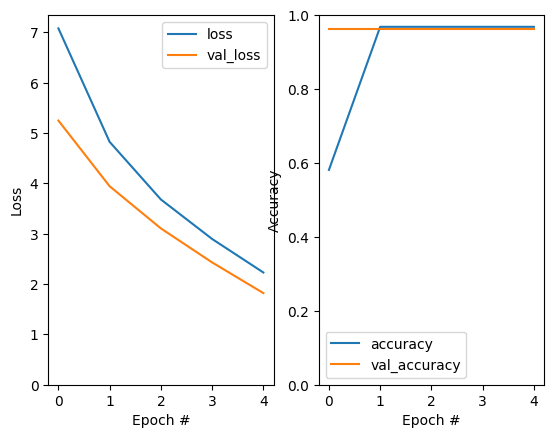

In [66]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [67]:
new_test_df = test_df[:750]
new_test_df

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."
...,...,...
745,"Students, parents and staff at a Melbourne hig...",A bubbler at a Melbourne high school has been ...
746,Steve Bruce is adamant he can keep Hull City i...,Steve Bruce adamant that Hull will avoid releg...
747,A 69-year-old mentally impaired man from Conne...,"Richard Lapointe, a former dishwasher, confess..."
748,Cate McGregor was surprised when she was uncon...,Cate McGregor is a Group Captain in the Royal ...


In [68]:
X_test= new_test_df['article'].values
y_test = new_test_df['highlights'].values

In [69]:
atricle_tokenizer = Tokenizer(num_words=2000, oov_token="<unk>")
atricle_tokenizer.fit_on_texts(X_test)
input_sequences = atricle_tokenizer.texts_to_sequences(X_test)
# Pad the sequences
max_vocab_size_en = 2000  
X_padded_test = pad_sequences(input_sequences, maxlen=max_vocab_size_en)
print(X_padded_test[0].shape)

(2000,)


In [70]:
highlights_tokenizer = Tokenizer(num_words=2000, oov_token="<unk>")
highlights_tokenizer.fit_on_texts(y_test)
output_sequences = highlights_tokenizer.texts_to_sequences(y_test)
# Pad the sequences
max_vocab_size = 2000
y_padded_test = pad_sequences(output_sequences, maxlen=max_summary_len)
print(y_padded_test[0].shape)

(1660,)


In [71]:
# Evaluate on test data if available
test_loss = model.evaluate([X_padded_test, y_padded_test], y_padded_test)

print(f"Test Loss: {test_loss}")

24/24 [==============================] - 5s 220ms/step - loss: 1.7718 - accuracy: 0.9686
Test Loss: [1.771761417388916, 0.968640148639679]


In [75]:
history = model.fit([padded_train_sequences_en, padded_train_sequences_de],
                    padded_train_sequences_de,
                    batch_size=32,
                    epochs=5,
                    validation_data=([padded_val_sequences_en, padded_val_sequences_de], padded_val_sequences_de)
                    )


Epoch 1/5
3/3 [==============================] - 2s 716ms/step - loss: 1.6292 - accuracy: 0.9683 - val_loss: 1.2881 - val_accuracy: 0.9625
Epoch 2/5
3/3 [==============================] - 2s 642ms/step - loss: 1.1291 - accuracy: 0.9683 - val_loss: 0.9011 - val_accuracy: 0.9625
Epoch 3/5
3/3 [==============================] - 2s 718ms/step - loss: 0.7781 - accuracy: 0.9683 - val_loss: 0.6614 - val_accuracy: 0.9625
Epoch 4/5
3/3 [==============================] - 2s 628ms/step - loss: 0.5663 - accuracy: 0.9683 - val_loss: 0.5342 - val_accuracy: 0.9625
Epoch 5/5
3/3 [==============================] - 2s 684ms/step - loss: 0.4557 - accuracy: 0.9683 - val_loss: 0.4728 - val_accuracy: 0.9625


In [76]:
test_loss = model.evaluate([X_padded_test, y_padded_test], y_padded_test)
print(f"Test Loss: {test_loss}")


24/24 [==============================] - 5s 226ms/step - loss: 0.3909 - accuracy: 0.9686
Test Loss: [0.3909311890602112, 0.968640148639679]


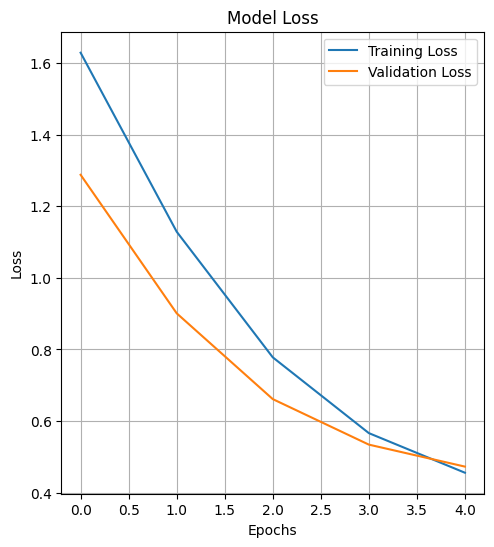

In [78]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot the loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()



In [83]:
from keras.preprocessing.sequence import pad_sequences

# Assuming input_sequences and output_sequences are defined
max_vocab_size_en = 2000
max_summary_len = 100  # Set this to the appropriate maximum length for summaries

# Pad the input sequences
X_padded = pad_sequences(input_sequences, maxlen=2000)
print(X_padded[0].shape)

# Pad the output sequences
y_padded = pad_sequences(output_sequences, maxlen=max_summary_len)
print(y_padded[0].shape)


(2000,)
(100,)


In [84]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(
    [padded_train_sequences_en, padded_train_sequences_de],
    padded_train_sequences_de,
    batch_size=32,
    epochs=5,
    validation_data=([padded_val_sequences_en, padded_val_sequences_de], padded_val_sequences_de)
)


Epoch 1/5
3/3 [==============================] - 5s 755ms/step - loss: 0.3956 - accuracy: 0.9683 - val_loss: 0.4247 - val_accuracy: 0.9625
Epoch 2/5
3/3 [==============================] - 2s 512ms/step - loss: 0.3511 - accuracy: 0.9683 - val_loss: 0.3970 - val_accuracy: 0.9625
Epoch 3/5
3/3 [==============================] - 2s 522ms/step - loss: 0.3186 - accuracy: 0.9683 - val_loss: 0.3481 - val_accuracy: 0.9625
Epoch 4/5
3/3 [==============================] - 2s 528ms/step - loss: 0.2671 - accuracy: 0.9683 - val_loss: 0.3003 - val_accuracy: 0.9627
Epoch 5/5
3/3 [==============================] - 1s 465ms/step - loss: 0.2434 - accuracy: 0.9690 - val_loss: 0.2897 - val_accuracy: 0.9635


In [85]:
import numpy as np

# Make predictions for the validation set
predictions = model.predict([padded_val_sequences_en, padded_val_sequences_de])
predicted_summaries = np.argmax(predictions, axis=-1)

# Convert predicted indices back to text
predicted_texts = tokenizer.sequences_to_texts(predicted_summaries)


1/1 [==============================] - 1s 877ms/step


In [87]:
# Assuming `data` is your DataFrame and it contains a 'highlights' column
actual_summaries = train_df['highlights'].values[:len(predicted_texts)]  # Ensure this matches the length of predicted texts


In [89]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from rouge_score import rouge_scorer

# Step 1: Pad the sequences
max_vocab_size_en = 2000
max_summary_len = 100  # Adjust this as necessary

# Assuming input_sequences and output_sequences are defined
X_padded = pad_sequences(input_sequences, maxlen=2000)
y_padded = pad_sequences(output_sequences, maxlen=max_summary_len)

# Step 2: Compile and Train the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(
    [padded_train_sequences_en, padded_train_sequences_de],
    padded_train_sequences_de,
    batch_size=32,
    epochs=5,
    validation_data=([padded_val_sequences_en, padded_val_sequences_de], padded_val_sequences_de)
)

# Step 3: Make Predictions
predictions = model.predict([padded_val_sequences_en, padded_val_sequences_de])
predicted_summaries = np.argmax(predictions, axis=-1)

# Convert predicted indices back to text
predicted_texts = tokenizer.sequences_to_texts(predicted_summaries)

# Step 4: Extract Actual Summaries
# Assuming `data` is your DataFrame and it contains a 'highlights' column
actual_summaries = train_df['highlights'].values[:len(predicted_texts)]

# Step 5: Calculate ROUGE Scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Prepare to store ROUGE scores and summaries
rouge_scores = {
    'rouge1': [],
    'rouge2': [],
    'rougeL': []
}

# Iterate over the predicted and actual summaries
for pred, actual in zip(predicted_texts, actual_summaries):
    scores = scorer.score(actual, pred)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

# Average ROUGE scores
average_rouge1 = np.mean(rouge_scores['rouge1'])
average_rouge2 = np.mean(rouge_scores['rouge2'])
average_rougeL = np.mean(rouge_scores['rougeL'])

print(f'Average ROUGE-1: {average_rouge1:.4f}')
print(f'Average ROUGE-2: {average_rouge2:.4f}')
print(f'Average ROUGE-L: {average_rougeL:.4f}')

# Print actual and predicted summaries for the first 10 articles
print("\n--- Actual and Predicted Summaries ---")
for i in range(10):  # Adjust the range as needed
    print(f"Article {i + 1}:")
    print(f"Actual Summary: {actual_summaries[i]}")
    print(f"Predicted Summary: {predicted_texts[i]}\n")


Epoch 1/5
3/3 [==============================] - 5s 745ms/step - loss: 0.2315 - accuracy: 0.9688 - val_loss: 0.2892 - val_accuracy: 0.9626
Epoch 2/5
3/3 [==============================] - 1s 485ms/step - loss: 0.2202 - accuracy: 0.9686 - val_loss: 0.2789 - val_accuracy: 0.9636
Epoch 3/5
3/3 [==============================] - 1s 485ms/step - loss: 0.2117 - accuracy: 0.9704 - val_loss: 0.2760 - val_accuracy: 0.9637
Epoch 4/5
3/3 [==============================] - 2s 498ms/step - loss: 0.2062 - accuracy: 0.9705 - val_loss: 0.2752 - val_accuracy: 0.9636
Epoch 5/5
1/1 [==============================] - 1s 516ms/step
Average ROUGE-1: 0.0295
Average ROUGE-2: 0.0000
Average ROUGE-L: 0.0287

--- Actual and Predicted Summaries ---
Article 1:
Actual Summary: Confirms West Napa Fault system was responsible for the 6.0 earthquake .
Reveals area of about 30x30 km was affected significantly .
Fault slip continues further north than previously thought .
system set to be used to monitor all future eart